In [1]:
import datetime
import h5py
import librosa
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import scipy.signal
import soundfile as sf
import sys
sys.path.append('../src')
import localmodule

from matplotlib import pyplot as plt


In [2]:
%matplotlib inline

# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
test_unit_id = 1

threshold_ids =\
      [[103, 102,  79, 115,   0,  91,   0, 106,   0, 135],
       [205,   0, 207,   0, 189, 170, 206, 193, 191, 184],
       [143,   0, 137, 150,   0, 158,   0, 145, 154, 118],
       [130, 158,   0, 136, 162, 133, 174, 134, 158, 140],
       [134, 131, 203, 126, 140, 131, 123, 121, 125, 139],
       [159, 186, 130, 133, 140, 161, 170, 141, 166, 168]]
threshold_ids = np.array(threshold_ids)

trials =\
      [[4, 8, 9, 6, 3, 0, 2, 1, 5, 7],
       [1, 3, 0, 9, 2, 6, 4, 8, 5, 7],
       [1, 4, 6, 8, 0, 9, 7, 5, 3, 2],
       [2, 9, 1, 5, 6, 3, 4, 8, 7, 0],
       [2, 8, 1, 0, 4, 9, 5, 7, 3, 6],
       [4, 9, 8, 6, 1, 2, 5, 3, 7, 0]]
trials = np.array(trials)

thresholds = 1.0 - np.concatenate((
    np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
))
n_thresholds = len(thresholds)

tolerance = 0.5 # in seconds

n_hours = 11
bin_hop = 30 # in minutes
n_bins = int(np.round(n_hours * (60/bin_hop)))
bins = (3600 * np.linspace(0, n_hours, 1 + n_bins)).astype('int')



# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


# Define directory for model.
test_unit_str = units[test_unit_id]
aug_str = "all"
model_name = "icassp-convnet"
model_dir = os.path.join(models_dir, model_name)


# Load annotation.
annotation_path = os.path.join(annotations_dir,
    test_unit_str + ".txt")
annotation = pd.read_csv(annotation_path, '\t')
begin_times = np.array(annotation["Begin Time (s)"])
end_times = np.array(annotation["End Time (s)"])
relevant = 0.5 * (begin_times + end_times)
relevant = np.sort(relevant)
high_freqs = np.array(annotation["High Freq (Hz)"])
low_freqs = np.array(annotation["Low Freq (Hz)"])
mid_freqs = 0.5 * (high_freqs + low_freqs)
n_relevant = len(relevant)

# Filter by frequency ranges.
thrush_low = 1000.0
thrush_high = 5000.0
thrush_relevant = relevant[(thrush_low < mid_freqs) & (mid_freqs < thrush_high)]
tseep_low = 5000.0
tseep_high = 10000.0
tseep_relevant = relevant[(tseep_low < mid_freqs) & (mid_freqs < tseep_high)]

plt.figure(figsize=(6,4))

thrush_Fs = []
tseep_Fs = []


thrush_Rs = []
tseep_Rs = []


# Loop over trials.
for trial_id_id in [5, 6, 7, 8, 9]:
    # Pick trial.
    trial_id = trials[test_unit_id, trial_id_id]


    # Pick threshold.
    threshold_id = threshold_ids[test_unit_id, trial_id]


    # Load prediction.
    test_unit_str = units[test_unit_id]
    unit_dir = os.path.join(model_dir, test_unit_str)
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(unit_dir, trial_str)
    prediction_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-predictions.csv"])
    prediction_path = os.path.join(trial_dir, prediction_name)
    prediction_df = pd.read_csv(prediction_path)
    odf = np.array(prediction_df["Predicted probability"])
    timestamps = np.array(prediction_df["Timestamp"])


    # Select peaks.
    threshold = thresholds[threshold_id]
    print(trial_id, threshold)
    peak_locations = peakutils.indexes(odf, thres=threshold, min_dist=3)
    selected = timestamps[peak_locations]
    
    # Match events for all calls.
    selected_relevant = mir_eval.util.match_events(relevant, selected, tolerance)
    tp_relevant_ids = list(zip(*selected_relevant))[0]
    tp_relevant_times = [relevant[i] for i in tp_relevant_ids]
    tp_selected_ids = list(zip(*selected_relevant))[1]
    tp_selected_times = [selected[i] for i in tp_selected_ids]
    
    # Compute number of false positives through time.
    fp_times = [selected[i] for i in range(len(selected)) if i not in tp_selected_ids]
    fp_x, fp_y = np.histogram(fp_times, bins=bins);

    # Match events for Thrush calls. Get number of true positives through time.
    thrush_selected_relevant = mir_eval.util.match_events(
        thrush_relevant, selected, tolerance)
    thrush_tp_relevant_ids = list(zip(*thrush_selected_relevant))[0]
    thrush_tp_relevant_times = [thrush_relevant[i] for i in thrush_tp_relevant_ids]
    thrush_tp_selected_ids = list(zip(*thrush_selected_relevant))[1]
    thrush_tp_selected_times = [selected[i] for i in thrush_tp_selected_ids]
    thrush_tp_x, thrush_tp_y = np.histogram(thrush_tp_relevant_times, bins=bins);
    
    # Get number of false negatives for Thrush.
    thrush_fn_times = [thrush_relevant[i] for i in range(len(thrush_relevant))
        if i not in thrush_tp_relevant_ids]
    thrush_fn_x, thrush_fn_y = np.histogram(thrush_fn_times, bins=n_bins);
    
    # Get Thrush precision through time.
    thrush_P = thrush_tp_x / (np.finfo(float).eps + thrush_tp_x + fp_x)
    thrush_R = thrush_tp_x / (np.finfo(float).eps + thrush_tp_x + thrush_fn_x)
    thrush_F = (2*thrush_P*thrush_R) / (np.finfo(float).eps + thrush_P + thrush_R)
                       
        
    # Match events for Thrush calls. Get number of true positives through time.
    tseep_selected_relevant = mir_eval.util.match_events(
        tseep_relevant, selected, tolerance)
    tseep_tp_relevant_ids = list(zip(*tseep_selected_relevant))[0]
    tseep_tp_relevant_times = [tseep_relevant[i] for i in tseep_tp_relevant_ids]
    tseep_tp_selected_ids = list(zip(*tseep_selected_relevant))[1]
    tseep_tp_selected_times = [selected[i] for i in tseep_tp_selected_ids]
    tseep_tp_x, tseep_tp_y = np.histogram(tseep_tp_relevant_times, bins=bins);
    
    # Get number of false negatives for Tseep.
    tseep_fn_times = [tseep_relevant[i] for i in range(len(tseep_relevant))
        if i not in tseep_tp_relevant_ids]
    tseep_fn_x, tseep_fn_y = np.histogram(tseep_fn_times, bins=n_bins);
    
    # Get Tseep precision through time.
    tseep_P = tseep_tp_x / (np.finfo(float).eps + tseep_tp_x + fp_x)
    tseep_R = tseep_tp_x / (np.finfo(float).eps + tseep_tp_x + tseep_fn_x)
    tseep_F = (2*tseep_P*tseep_R) / (np.finfo(float).eps + tseep_P + tseep_R)
    
    thrush_Fs.append(thrush_F)
    tseep_Fs.append(tseep_F)
    
    thrush_Rs.append(thrush_R)
    tseep_Rs.append(tseep_R)

6 0.553316407849
4 0.832119598188
8 0.811635091051
5 0.943765867481
7 0.788651096016


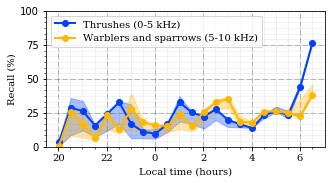

In [41]:
import matplotlib.pylab


utc_timestamp = 1443065462
utc_datetime = datetime.datetime.fromtimestamp(utc_timestamp)
utc_offset =\
    utc_datetime.hour +\
    utc_datetime.minute / 60 +\
    utc_datetime.second / 3600
local_offset = utc_offset - 4
first_hour = 20
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(5, 2.5))


thrush_R_Q1 = np.sort(np.stack(thrush_Rs), axis=0)[1]
thrush_R_med = np.sort(np.stack(thrush_Rs), axis=0)[2]
thrush_R_Q3 = np.sort(np.stack(thrush_Rs), axis=0)[3]

thrush_F_Q1 = np.sort(np.stack(thrush_Fs), axis=0)[1]
thrush_F_med = np.sort(np.stack(thrush_Fs), axis=0)[2]
thrush_F_Q3 = np.sort(np.stack(thrush_Fs), axis=0)[3]

ax1.fill_between(
    thrush_tp_y[1:] / 3600 + local_offset,
    100 * thrush_F_Q1[:],
    100 * thrush_F_Q3[:],
    color = "#0040FF",
    alpha = 0.33)

ax1.plot(
    thrush_tp_y[1:] / 3600 + local_offset,
    100 * thrush_F_med[:],
    "-o",
    color = "#0040FF",
    linewidth = 2.0)


tseep_R_Q1 = np.sort(np.stack(tseep_Rs), axis=0)[1]
tseep_R_med = np.sort(np.stack(tseep_Rs), axis=0)[2]
tseep_R_Q3 = np.sort(np.stack(tseep_Rs), axis=0)[3]

tseep_F_Q1 = np.sort(np.stack(tseep_Fs), axis=0)[1]
tseep_F_med = np.sort(np.stack(tseep_Fs), axis=0)[2]
tseep_F_Q3 = np.sort(np.stack(tseep_Fs), axis=0)[3]


ax1.fill_between(
    tseep_tp_y[1:] / 3600 + local_offset,
    100 * tseep_F_Q1[:],
    100 * tseep_F_Q3[:],
    color = "#FFB800",
    alpha = 0.33)

ax1.plot(
    tseep_tp_y[1:] / 3600 + local_offset,
    100 * tseep_F_med[:],
    "-o",
    color = "#FFB800",
    linewidth = 2.0)

ax1.legend(["Thrushes (0-5 kHz)", "Warblers and sparrows (5-10 kHz)"],
    loc=2, prop={'family':'serif'})

ax1.set_xticks(range(first_hour, first_hour+n_hours+1)[::2])
ax1.set_xticklabels([str(np.mod(n, 24))
    for n in range(first_hour, first_hour+n_hours+1)][::2], family="serif")
ax1.set_xticks(
    np.linspace(first_hour, first_hour+n_hours - 0.5, n_hours * 2),
    minor=True)
ax1.set_xlabel("Local time (hours)", family="serif")

ax1.set_ylim(0, 100)
ax1.set_ylabel("Recall (%)", family="serif")
ax1.set_yticks(np.linspace(0, 100, 5))
ax1.set_yticks(np.linspace(0, 100, 25), minor=True)

ax1.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax1.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax1.set_axisbelow(True)

plt.savefig("icassp_fig_recall-time_a.png", dpi=500, bbox_inches="tight")


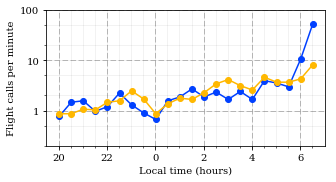

In [40]:
thrush_y = np.zeros((n_bins, n_units))
tseep_y = np.zeros((n_bins, n_units))

# Loop over units.
for unit_id in range(n_units):

    unit_str = units[unit_id]
    annotation_path = os.path.join(annotations_dir,
        unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    high_freqs = np.array(annotation["High Freq (Hz)"])
    low_freqs = np.array(annotation["Low Freq (Hz)"])
    mid_freqs = 0.5 * (high_freqs + low_freqs)
    n_relevant = len(relevant)

    thrush_relevant = relevant[(thrush_low < mid_freqs) & (mid_freqs < thrush_high)]
    thrush_y[:, unit_id] = np.histogram(thrush_relevant, bins=bins)[0]
    

    tseep_relevant = relevant[(tseep_low < mid_freqs) & (mid_freqs < tseep_high)]
    tseep_y[:, unit_id] = np.histogram(tseep_relevant, bins=bins)[0]

fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(5, 2.5))

ax2.plot(
    thrush_tp_y[1:] / 3600 + local_offset,
    np.log10((thrush_tp_x + thrush_fn_x) / bin_hop),
    "-o",
    color = "#0040FF")

ax2.plot(
    tseep_tp_y[1:] / 3600 + local_offset,
    np.log10((tseep_tp_x + tseep_fn_x) / bin_hop),
    "-o",
    color = "#FFB800")

ax2.set_xticks(range(first_hour, first_hour+n_hours+1)[::2])
ax2.set_xticklabels([str(np.mod(n, 24))
    for n in range(first_hour, first_hour+n_hours+1)][::2], family="serif")
ax2.set_xticks(
    np.linspace(first_hour, first_hour+n_hours - 0.5, n_hours * 2),
    minor=True)
ax2.set_xlabel("Local time (hours)", family="serif")

yticks = [0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
ax2.set_yticks(np.log10(yticks), minor=True)
ax2.set_yticks(np.log10([1, 10, 100]))
ax2.set_yticklabels(map(str, [1, 10, 100]), family="serif");

ax2.set_ylabel("Flight calls per minute", family="serif")

ax2.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax2.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax2.set_axisbelow(True)

plt.savefig("icassp_fig_recall-time_b.png", dpi=500, bbox_inches="tight")



In [ ]:
dataset_name = localmodule.get_dataset_name()

full_logmelspec_name = "_".join([dataset_name, "full-logmelspec"])
full_logmelspec_dir = os.path.join(data_dir, full_logmelspec_name)
logmelspec_path = os.path.join(full_logmelspec_dir, test_unit_str + ".hdf5")

logmelspec_file = h5py.File(logmelspec_path)

lms_fmin = logmelspec_file["logmelspec_settings"]["fmax"].value
lms_fmax = logmelspec_file["logmelspec_settings"]["fmin"].value
lms_sr = logmelspec_file["logmelspec_settings"]["sr"].value
lms_hop_length = logmelspec_file["logmelspec_settings"]["hop_length"].value
lms_hop_duration = lms_hop_length / lms_sr
n_hops_per_bin = int(bin_hop * 60 / lms_hop_duration)

mel_f = librosa.core.mel_frequencies(
    logmelspec_file["logmelspec_settings"]["n_mels"].value + 2,
    fmin=logmelspec_file["logmelspec_settings"]["fmin"].value,
    fmax=logmelspec_file["logmelspec_settings"]["fmax"].value,
    htk=False)

thrush_mel_start = np.argmin(np.abs(thrush_low - mel_f))
thrush_mel_stop = np.argmin(np.abs(thrush_high - mel_f))

tseep_mel_start = np.argmin(np.abs(tseep_low - mel_f))
tseep_mel_stop = np.argmin(np.abs(tseep_high - mel_f))

thrush_percentiles = []
tseep_percentiles = []

for bin_id in range(n_bins):
    print(bin_id)
    
    bin_start = bin_id * n_hops_per_bin
    bin_stop = bin_start + n_hops_per_bin
    
    thrush_fragment = logmelspec_file["logmelspec"][
        thrush_mel_start:thrush_mel_stop, bin_start:bin_stop]
    thrush_percentiles.append(np.percentile(thrush_fragment, [25, 50, 75]))
    
    
    tseep_fragment = logmelspec_file["logmelspec"][
        tseep_mel_start:tseep_mel_stop, bin_start:bin_stop]
    tseep_percentiles.append(np.percentile(tseep_fragment, [25, 50, 75]))
    

logmelspec_file.close()

thrush_percentiles = np.stack(thrush_percentiles)
tseep_percentiles = np.stack(tseep_percentiles)

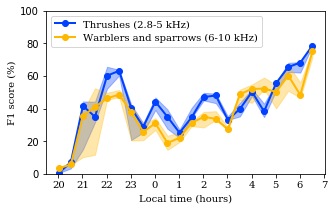

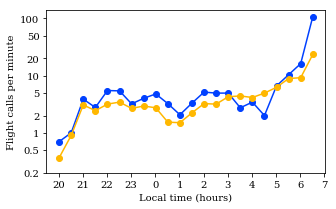

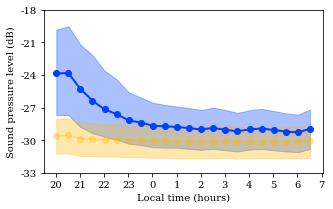

In [29]:
fig, ax3 = plt.subplots(1, 1, sharex=True, figsize=(5, 3))

ax3.fill_between(
    thrush_tp_y[1:] / 3600 + local_offset,
    thrush_percentiles[:, 0],
    thrush_percentiles[:, 2],
    color = "#0040FF",
    alpha = 0.33);

ax3.plot(
    thrush_tp_y[1:] / 3600 + local_offset,
    thrush_percentiles[:, 1],
    "-o",
    color = "#0040FF",
    linewidth = 2.0)


ax3.fill_between(
    tseep_tp_y[1:] / 3600 + local_offset,
    tseep_percentiles[:, 0],
    tseep_percentiles[:, 2],
    color = "#FFB800",
    alpha = 0.33);

ax3.plot(
    tseep_tp_y[1:] / 3600 + local_offset,
    tseep_percentiles[:, 1],
    "-o",
    color = "#FFB800",
    alpha = 0.33)

ax3.set_xticks(range(first_hour, first_hour+n_hours+1))
ax3.set_xticklabels([str(np.mod(n, 24))
    for n in range(first_hour, first_hour+n_hours+1)], family="serif")
ax3.set_xlabel("Local time (hours)", family="serif")

ydBs = [-33, -30, -27, -24, -21, -18]
ax3.set_yticks(ydBs)
ax3.set_yticklabels([str(ydB) for ydB in ydBs], family="serif");
ax3.set_ylabel("Sound pressure level (dB)", family="serif")

plt.savefig("icassp_fig_recall-time_c.png", dpi=144)

R = 0.89, p = 5e-16 ; n = 44


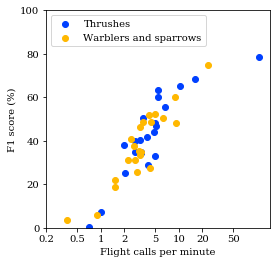

In [6]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))

ax.scatter(
    np.log10((thrush_tp_x + thrush_fn_x) / bin_hop),
    100 * thrush_F_med[:],
    c = "#0040FF")


ax.scatter(
    np.log10((tseep_tp_x + tseep_fn_x) / bin_hop),
    100 * tseep_F_med[:],
    c = "#FFB800")



ax.legend(
    ["Thrushes", "Warblers and sparrows"],
    loc=2,
    prop={'family':'serif','weight':'roman'})

xticks = [0.2, 0.5, 1, 2, 5, 10, 20, 50]
ax.set_xticks(np.log10(xticks))
ax.set_xticklabels([str(xtick) for xtick in xticks], family="serif")
ax.set_xlabel("Flight calls per minute", family="serif")

ax.set_ylim(0, 100);
ax.set_ylabel("F1 score (%)", family="serif")
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(
    [str(F) for F in np.linspace(0, 100, 6).astype('int')],
    family="serif")


mixed_log10_x = np.concatenate([np.log10(thrush_tp_x + thrush_fn_x), np.log10(tseep_tp_x + tseep_fn_x)])
mixed_y = np.concatenate([100 * thrush_F_med[:], 100 * tseep_F_med[:]])
mixed_R, mixed_p = scipy.stats.pearsonr(mixed_log10_x, mixed_y)
print("R = {:3.2f}, p = {:1.0e} ; n = {}".format(mixed_R, mixed_p, len(mixed_y)))

Thrushes. R = -0.59 ; p = 4e-03 ; n = 22
Warblers and sparrows. R = -0.58 ; p = 4e-03 ; n = 22


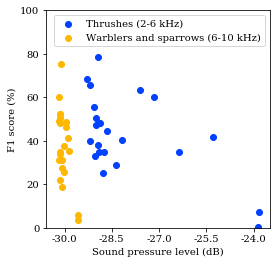

In [8]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))
thrush_med_noise = thrush_percentiles[:, 1]
thrush_med_noise = thrush_med_noise - np.mean(thrush_med_noise)
thrush_med_noise = thrush_med_noise / np.std(thrush_med_noise)
tseep_med_noise = tseep_percentiles[:, 1]

ax.scatter(
    thrush_med_noise,
    100 * thrush_F_med[:],
    c = "#0040FF")

ax.scatter(
    tseep_med_noise,
    100 * tseep_F_med[:],
    c = "#FFB800")

ax.legend(
    ["Thrushes (2-6 kHz)", "Warblers and sparrows (6-10 kHz)"],
    loc=1,
    prop={'family':'serif'})

xticks = [-30.0, -28.5, -27.0, -25.5, -24.0]
ax.set_xticks(xticks)
ax.set_xticklabels([str(xtick) for xtick in xticks], family="serif")
ax.set_xlabel("Sound pressure level (dB)", family="serif")

ax.set_ylim(0, 100);
ax.set_ylabel("F1 score (%)", family="serif")
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(
    [str(F) for F in np.linspace(0, 100, 6).astype('int')],
    family="serif")


thrush_noise_R, thrush_noise_p = scipy.stats.pearsonr(thrush_med_noise, 100*thrush_F_med[:])
print("Thrushes. R = {:3.2f} ; p = {:1.0e} ; n = {}".format(thrush_noise_R, thrush_noise_p, len(thrush_med_noise)))

tseep_noise_R, tseep_noise_p = scipy.stats.pearsonr(tseep_med_noise, 100*tseep_F_med[:])
print("Warblers and sparrows. R = {:3.2f} ; p = {:1.0e} ; n = {}".format(tseep_noise_R, tseep_noise_p, len(tseep_med_noise)))